In [18]:
''' Primary libraries to import '''

import numpy as np # for numerical operations
import pandas as pd # for data loading, grouping and aggregation
import matplotlib.pyplot as plt # basic plots
# import seaborn as sns # nicer visuals

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)



In [19]:
'''
Data Loading and Initial Exploration:
    - Load the dataset 
    - Display dataset structure and size
    - Display the first 5 rows and check the data types of all columns.
    - Missing values.
'''

# Loading the dataset into a pandas DataFrame

df = pd.read_csv("query-water-efficiency-data (1).csv")


In [20]:

# Create a function which store and display information related to dataset inspection

def inspect_data(filepath):
    
    df = pd.read_csv(filepath)

    print("\nFirst look at the dataset:")
    print(df.head())
    print("\nDataset shape:")
    print(f"{df.shape[0]} rows × {df.shape[1]} columns")
    print("\nData types:")
    print(df.dtypes)
    print("\nChecking for NaN values:")
    print(df.isna().sum())
    print(f"\nNumber of countries: {df['country'].nunique()}")

    countries_list = df["country"].unique()
    print("\nCountries represented in the dataset:")
    for country in countries_list:
        print(country)

    return df


# Diplay the function

df = inspect_data("query-water-efficiency-data (1).csv")



First look at the dataset:
   country climate_region        date  hour  avg_temperature  avg_humidity  avg_wetbulb_temperature  avg_wind_speed  avg_precipitation  avg_wue_fixed  avg_wue_indirect  avg_total_renewables_twh  avg_total_fossil_twh  avg_total_energy_twh
0  Algeria  Mediterranean  2022-08-20     0            22.02          64.3                63.175698            6.04                0.0       1.641379          1.413949               5957.804724         766629.284363         772587.089087
1  Algeria  Mediterranean  2022-08-20     1            21.42          64.7                62.305006            5.32                0.0       1.635311          1.413949               5957.804724         766629.284363         772587.089087
2  Algeria  Mediterranean  2022-08-20     2            20.84          65.0                61.430778            4.58                0.0       1.628322          1.413949               5957.804724         766629.284363         772587.089087
3  Algeria  Mediterr

                         start_date   end_date  coverage_days
country                                                      
Algeria                  2022-08-20 2024-08-04            716
Benin                    2022-08-20 2023-08-20            366
Botswana                 2022-08-20 2023-08-20            366
Burkina Faso             2022-08-20 2023-08-20            366
Burundi                  2022-08-20 2023-08-20            366
Cameroon                 2022-08-20 2023-08-20            366
Cape Verde               2022-08-20 2023-08-20            366
Central African Republic 2022-08-20 2023-08-20            366
Chad                     2022-08-20 2023-08-20            366
Egypt                    2022-08-20 2023-08-20            366
Equatorial Guinea        2022-08-20 2023-08-20            366
Eritrea                  2022-08-20 2023-08-20            366
Ethiopia                 2022-08-20 2023-08-20            366
Gabon                    2022-08-20 2023-08-20            366
Ghana   

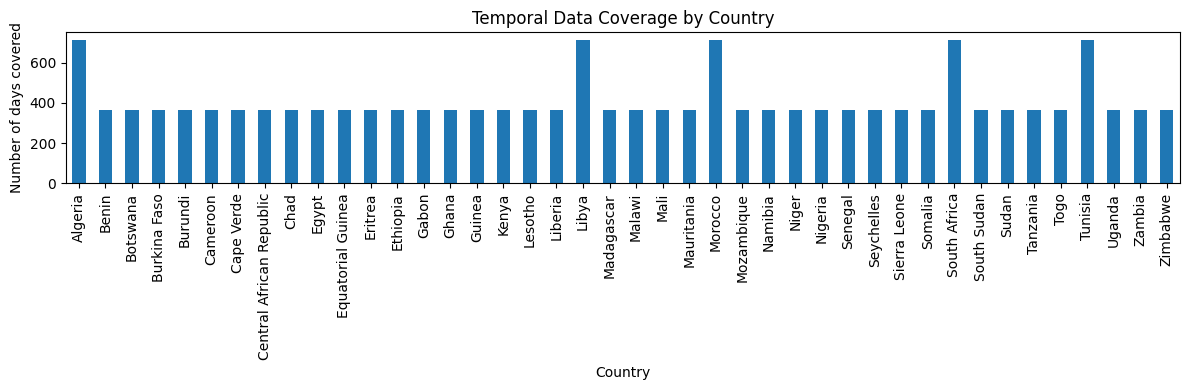

In [ ]:
# Coverage days by country to understand the time span of observations per country 

df["date"] = pd.to_datetime(df["date"]) # datetime object
coverage = (
    df.groupby("country")["date"]
      .agg(start_date="min", end_date="max") # group by country and extract date range
)
coverage["coverage_days"] = (
    coverage["end_date"] - coverage["start_date"]
).dt.days + 1 # compute numbers of days covered
coverage.sort_values("coverage_days", ascending=False) # sort them by coverage lentgh

print(coverage)

# Bar chart to diplay date coverage distribution in a more visual way

coverage["coverage_days"].plot(
    kind="bar",
    figsize=(12, 4)
)

plt.ylabel("Number of days covered")
plt.xlabel("Country")
plt.title("Temporal Data Coverage by Country")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
